In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'eurosat-rgb:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F723027%2F1257124%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T205400Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbead7dceceb8e663d7a839aebceb9a00410cb81e8d346a58382ce8ecad55579ec11da342bf3acf4762db8a76e5a2fb9b9ac282b832981ec490bcf009cc8a912caf24e93df2d2deffd53b58b28c903b6e73aa9d9437b9dafd6d22cf7ac38079a5e3e888c4390a1dc83519a0c71e4227045e279366f846fb49d8c188cba6edcf058042e87906d17d0339817f38a255a9e3ea43c429115b18966c1f1c47b036dd53140e980047009a146f72e7b87715cd98196ea1948b0d3a0c966141e03cdde81e9f2afc1ce359e7f1dd6b653b159b020f3b45c30b76dd7c59d13ed411e32b5e0babadd69f8a170166178c9048096d62775c815f3823c3938726bcb867f47daac7,satellite-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1544742%2F2546969%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T205400Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3De30207845d7c69edd830e96908bd707a44235548f40f7e233e8fc1d17ee1e8ab37d16325bb38b240519f87ee9b4d7a919cd165cc1197770147313c02cf4b65af439806eab82250090f2ac8d1a3ed8a8d65f459fb6df4fcd562fea8a418a402f1f05b6d2abde428bd43b4e74135adef9b10af2f876f710419c4b0cdafb232186b72f7af9e7ff0e3a18df41febcbd3921cf9ce5410d33cf62a9fd773f89bd5ee2c928e2868f4b8f08d65096ad0b4df8979adbef1db30a1bea7bf9514de8b26fb675bde99af10c84f050894265f678669d6d813d6d3999152d7665460360d9739c989acaa901d9ae4c1537305400cb7a306bb9259b78ae1323bc9927b3d529e7410,dataset2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4712074%2F8001678%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T205400Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2278ed7d1b26b44de8cd530ab81a0541ed137d7d8e7bf7464f9f15ea14635c4878351ae2be5facb8efe67b1a7ad3e9ee06b9d61eebcc34f5e5443837f1762f626d2e6afe80adb41074dacffd366e5f2bf923c8a70f8ad3a717a969b4d42b2b163ce4b75fb416832596b1ff3f6e6f0a4f1cb363617e3235b20c68b64054606e8dbedbaf8265f04a02eab9cce97de4a825094204e6e5c50af8bd880c56991ac0e14b60c5e9738f379b44ac8e741e3451d8beb00bb4506d75ddcf5ec6dc3b2a2c17865cd767e65d292e95cd72c8a7826d903b5835fff5b7cd6da37cc60c3f46f2fe90bf4af1920c19b39ff1b29c2e179931c6d1711a6d5e103c1909e09f3bba1d04'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 93939673 bytes downloaded
Downloaded and uncompressed: eurosat-rgb
[==================================================] 22836290 bytes downloaded
Downloaded and uncompressed: satellite-image-classification
[==================================================] 3380 bytes downloaded
Downloaded and uncompressed: dataset2
Data source import complete.


In [2]:


#!unzip -q "/content/kaggle/input/eurosat-rgb/2750" -d "/content/"


In [3]:
import os
import numpy as np
from PIL import Image, ImageFilter
import torchvision
import cv2
import torch,torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from itertools import cycle
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
version = "Dataset2"
model_name = "vgg16_dataset_2"

In [5]:
torch.cuda.is_available()


True

In [6]:
def load_data(path, test_split, val_split, batch_size, input_size):

    transform_dict={'src':transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.Resize((64,64)),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}

    data1 = datasets.ImageFolder(root=path,transform =transform_dict['src'])
    test_size=int(len(data1)*test_split)
    val_size=int(len(data1)*val_split)
    train_size=len(data1)-val_size-test_size
    train_dataset,test_dataset,val_dataset = torch.utils.data.random_split(data1,[train_size,test_size,val_size])
    data_loader_train=DataLoader(train_dataset,batch_size,shuffle=True)
    data_loader_test=DataLoader(test_dataset,batch_size,shuffle=False)
    data_loader_val=DataLoader(val_dataset,batch_size,shuffle=False)
    return data_loader_train, data_loader_test, data_loader_val

In [7]:
train_loader,test_loader,val_loader=load_data(path=r'/kaggle/input/eurosat-rgb/2750',
                                              test_split=0.15,val_split= 0.2,batch_size=16, input_size=[64,64])


In [8]:
model = torchvision.models.vgg16(pretrained=False, num_classes=10)

optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [9]:
num_epochs = 50
train_losses = []
train_accs = []
val_accs = []
val_losses = []


patience = 10
delta = 0.001
best_val_loss = float('inf')
best_model_state_dict = None
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        val_loss /= len(val_loader.dataset) #Val loss and acc for each epoch
        val_acc = 100 * correct / total

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


Epoch 1/50, Train Loss: 7667.6179, Train Accuracy: 11.12%, Validation Loss: 0.1438, Validation Accuracy: 10.54%
Epoch 2/50, Train Loss: 2.2963, Train Accuracy: 11.60%, Validation Loss: 0.1437, Validation Accuracy: 11.11%
Epoch 3/50, Train Loss: 2.2962, Train Accuracy: 10.78%, Validation Loss: 0.1437, Validation Accuracy: 10.80%
Epoch 4/50, Train Loss: 2.2957, Train Accuracy: 10.86%, Validation Loss: 0.1436, Validation Accuracy: 11.52%
Epoch 5/50, Train Loss: 2.2958, Train Accuracy: 10.91%, Validation Loss: 0.1437, Validation Accuracy: 11.11%
Epoch 6/50, Train Loss: 2.2960, Train Accuracy: 10.94%, Validation Loss: 0.1437, Validation Accuracy: 10.54%
Epoch 7/50, Train Loss: 2.2960, Train Accuracy: 10.80%, Validation Loss: 0.1437, Validation Accuracy: 10.80%
Epoch 8/50, Train Loss: 2.2958, Train Accuracy: 11.03%, Validation Loss: 0.1437, Validation Accuracy: 10.80%
Epoch 9/50, Train Loss: 2.2958, Train Accuracy: 11.28%, Validation Loss: 0.1437, Validation Accuracy: 11.11%
Epoch 10/50, Tra

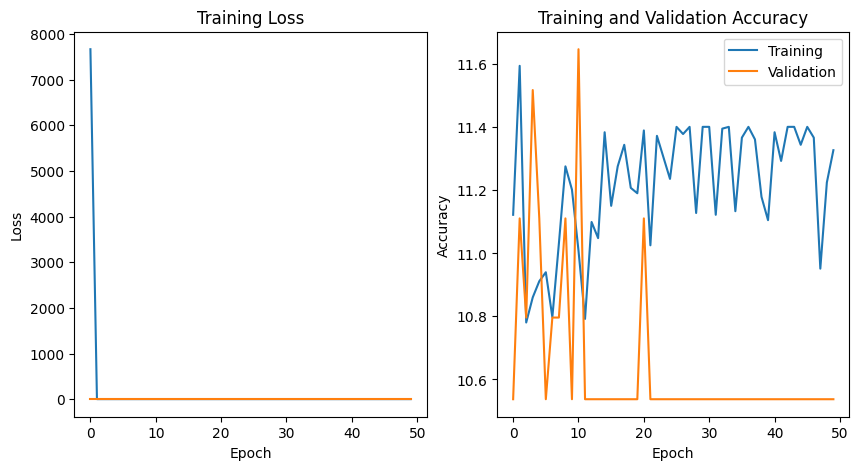

In [10]:
# Plot training accuracy and loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label='Training')
plt.plot(val_losses, label='Validation')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Training')
plt.plot(val_accs, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig(f"train-val_{version}.png",dpi=300)
plt.legend()

In [11]:
# Evaluation on test set and ROC curve
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # For ROC curve
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())  # Predicted probabilities for all classes

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}')
# Save the model
torch.save(model.state_dict(), f'{model_name}.pth')


Test Accuracy: 10.617283950617283


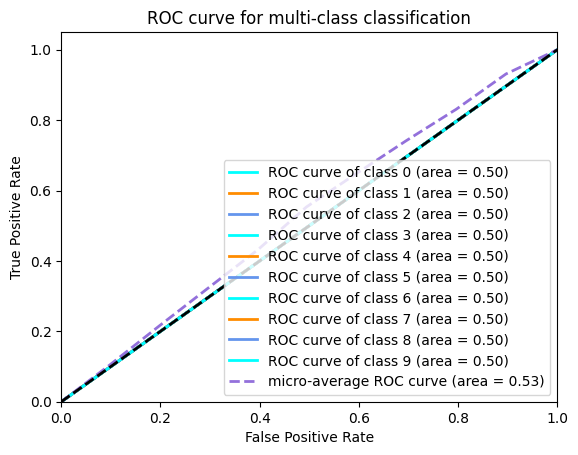

In [12]:
from sklearn.metrics import roc_curve, auc
num_classes = 10
# Convert labels to one-hot encoding
y_true_onehot = label_binarize(y_true, classes=np.arange(num_classes))

# Convert y_pred list to numpy array
y_pred = np.array(y_pred)

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot(fpr["micro"], tpr["micro"], color='mediumpurple', lw=lw, linestyle='--',
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multi-class classification')
plt.legend(loc="lower right")
plt.savefig(f"roc{version}.png",dpi=300)
plt.show()

4050 4050
report:                       precision    recall  f1-score   support

          AnnualCrop       0.11      1.00      0.19       430
              Forest       0.00      0.00      0.00       445
HerbaceousVegetation       0.00      0.00      0.00       438
             Highway       0.00      0.00      0.00       384
          Industrial       0.00      0.00      0.00       379
             Pasture       0.00      0.00      0.00       279
       PermanentCrop       0.00      0.00      0.00       405
         Residential       0.00      0.00      0.00       436
               River       0.00      0.00      0.00       363
             SeaLake       0.00      0.00      0.00       491

            accuracy                           0.11      4050
           macro avg       0.01      0.10      0.02      4050
        weighted avg       0.01      0.11      0.02      4050



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


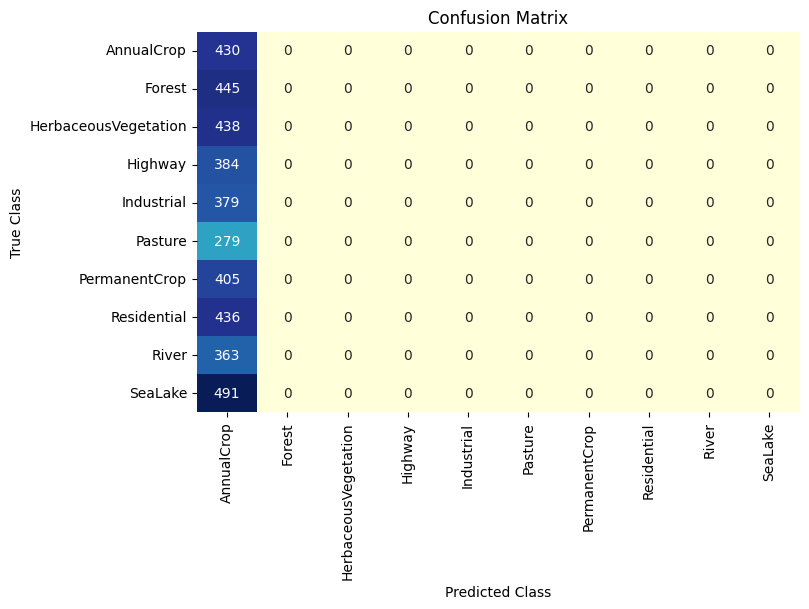

In [16]:
#confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
y_true = []
y_pred = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    y_true.extend(labels.cpu().numpy())  # transfer tensor to CPU and convert to numpy array

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
print(len(y_true), len(y_pred))
class_names = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake')
report = classification_report(y_true, y_pred, target_names=class_names)
print(f"report:", report)
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"),
plt.xlabel("Predicted Class")
plt.savefig(f"cf_{version}.png",dpi=300)
plt.show()